### Pilot Run, lolz

In [1]:
import os
os.chdir('src/')

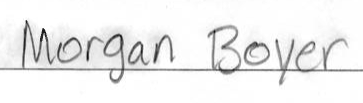

In [2]:
from IPython.display import Image
Image('../page_0_name.png')

In [3]:
import cv2
import editdistance
import matplotlib.pyplot as plt
import numpy as np

from DataLoader import DataLoader, Batch
from Model import Model, DecoderType
from SamplePreprocessor import preprocess

In [4]:
# Useful funcs
def show_img(img):
    plt.figure(figsize = (20,10))
    plt.imshow(img)

def load_model(decoder_type):
    return Model(charList=open('../model/charList.txt').read(),
                 decoderType=decoder_type,
                 mustRestore=True,
                 dump=False)

# model = load_model(decoder_type=DecoderType.BestPath)

### Increase Contrast

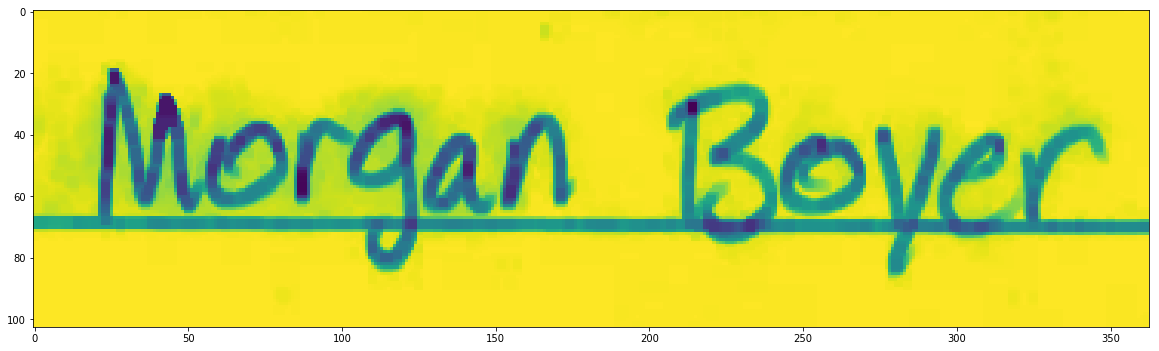

In [5]:
def increase_contrast(img):
    pxmin = np.min(img)
    pxmax = np.max(img)
    return (img - pxmin) / (pxmax - pxmin) * 255 

def thicken_lines(img_contrast):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img_contrast, kernel, iterations = 1)

# prep 
img = cv2.imread('../page_0_name.png', cv2.IMREAD_GRAYSCALE)
img_contrast = increase_contrast(img)
thick = thicken_lines(img_contrast)

show_img(thick)

In [8]:
def infer_single(model, img):
    prep = preprocess(img, model.imgSize)
    batch = Batch(None, [prep])
    (recognized, probability) = model.inferBatch(batch, True)
    print('Recognized: ', recognized[0])
    print('Prob: ', probability[0])
    return recognized, probability

In [7]:
# Better
infer_single(model=model, img=thick)

Recognized:  Mergansevec
Prob:  0.0016730939


(['Mergansevec'], array([0.00167309], dtype=float32))

In [8]:
editdistance.eval('Mergansevec', 'Morgan Boyer')

6

### Try cropping first name

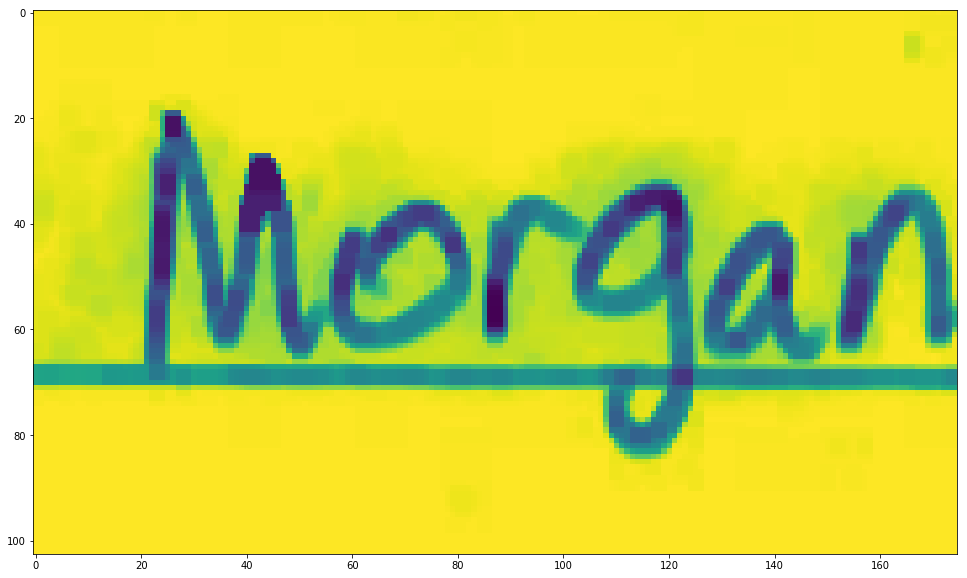

In [6]:
first_crop = thick[:,:175]
show_img(first_crop)

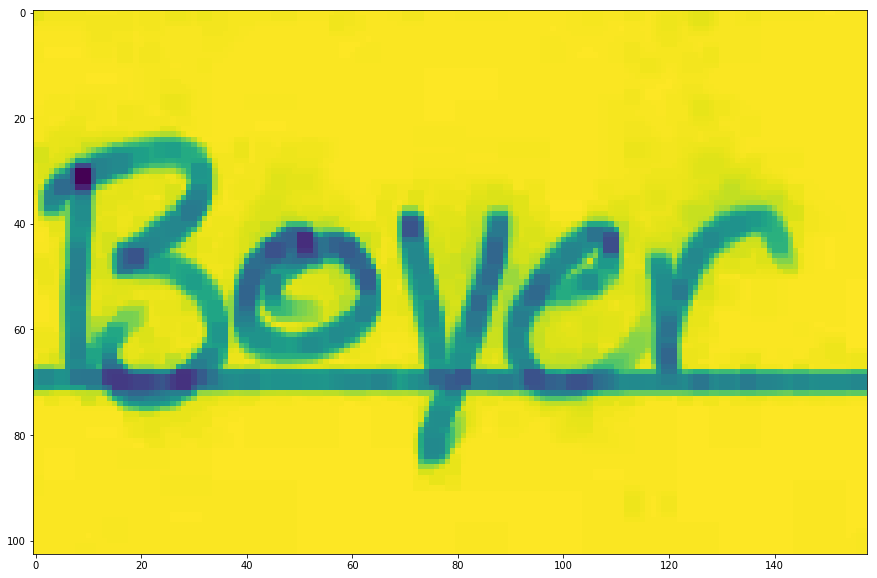

In [7]:
last_crop = thick[:,205:]
show_img(last_crop)

In [11]:
# Wondering if it picks up on the (under)line?
# Can we remove?
guess, prob = infer_single(model=model, img=first_crop)
editdistance.eval(guess[0], "Morgan")

Recognized:  leerges
Prob:  0.02215204


5

In [12]:
guess, prob = infer_single(model=model, img=last_crop)
editdistance.eval(guess[0], "Boyer")

Recognized:  Beyec
Prob:  0.18840815


2

### Maybe a different Decoder Type would work?

In [ ]:
# Beam search returns a period? Lol
infer_single(model=model, img=img)

### Remove Horizontal Line ?

In [18]:
# https://stackoverflow.com/questions/46281623/delete-segmented-lines-opencv-python
# https://stackoverflow.com/questions/46274961/removing-horizontal-lines-in-image-opencv-python-matplotlib?noredirect=1#comment79515464_46274961

import math


# gray = cv2.cvtColor(first_crop, cv2.COLOR_BGR2GRAY)
temp = np.uint8(first_crop)
edges = cv2.Canny(temp, 80, 120)
lines = cv2.HoughLinesP(edges, 1, math.pi/2, 2, None, 30, 1)

In [19]:
slines

array([[[ 27,  67, 143,  67]],

       [[ 26,  71, 108,  71]]], dtype=int32)

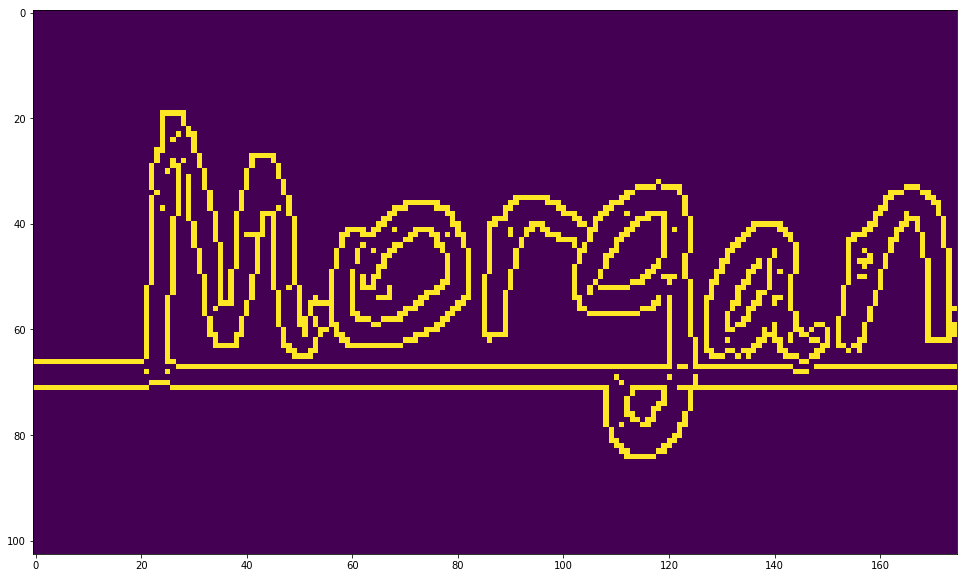

In [20]:
show_img(edges)

In [ ]:
lines[0]

In [ ]:
no_line.shape

In [ ]:
x1,y1,x2,y2 = lines[0][0]
no_line = gray.copy()
no_line = cv2.line(no_line, (x1, y1), (x2, y2), (255, ), 1)
show_img(no_line)

### Create IAM Style Dataset

In [1]:
with open('name_labels.txt', 'r') as f:
    word_list = [x.strip() for x in f.readlines()]

In [2]:
import os
image_paths = ['name_crops/{}'.format(x) for x in sorted(os.listdir('name_crops/')) if 'png' in x]

In [9]:
import numpy as np
import cv2


class DataProvider():
    "this class creates machine-written text for a word list. TODO: change getNext() to return your samples."

    def __init__(self, word_list, image_paths):
        assert len(word_list) == len(image_paths), 'Labels and Images are wrong length'
        self.word_list = word_list
        self.image_paths = image_paths

#     def hasNext(self):
#         "are there still samples to process?"
#         return self.idx < len(self.wordList)

    def __iter__(self):
        for word, im_pth in zip(self.word_list, self.image_paths):
            image = cv2.imread(im_pth)
            yield word, image

    def getNext(self):
        "TODO: return a sample from your data as a tuple containing the text and the image"
#         img = np.ones((32, 128), np.uint8)*255
#         word = self.wordList[self.idx]
#         self.idx += 1
#         cv2.putText(img, word, (2,20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0), 1, cv2.LINE_AA)
        
        return (word, img)


def createIAMCompatibleDataset(dataProvider):
    "this function converts the passed dataset to an IAM compatible dataset"

    # create files and directories
    f = open('words.txt', 'w+')
    if not os.path.exists('sub'):
        os.makedirs('sub')
    if not os.path.exists('sub/sub-sub'):
        os.makedirs('sub/sub-sub')

    # go through data and convert it to IAM format
    ctr = 0
    for sample in dataProvider:
        
        # write img
        cv2.imwrite('sub/sub-sub/sub-sub-%d.png'%ctr, sample[1])
        
        # write filename, dummy-values and text
        line = 'sub-sub-%d'%ctr + ' X X X X X X X ' + sample[0] + '\n'
        f.write(line)
        
        ctr += 1


In [6]:
import cv2
import matplotlib.pyplot as plt

dp = DataProvider(word_list, image_paths)
for word, im in dp:
    break
print(word)


Morgan Boyer


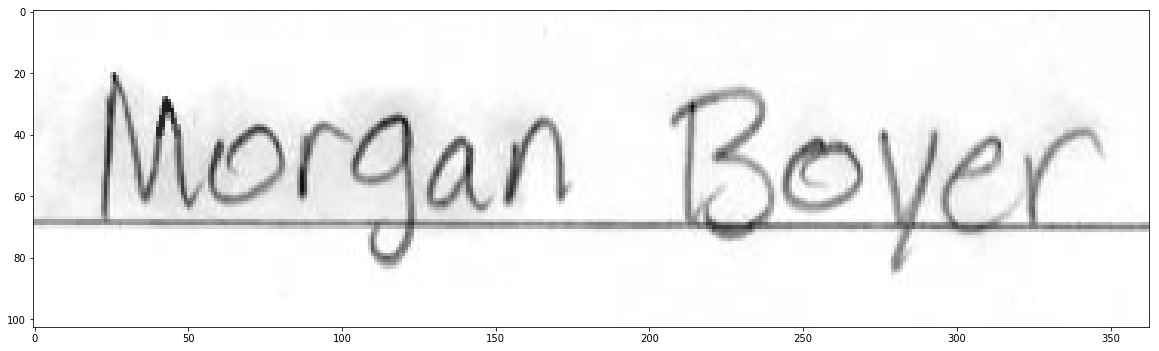

In [7]:
show_img(im)

In [10]:
createIAMCompatibleDataset(dp)